# 2. Análisis de audios como datos brutos

In [1]:
from scipy.io import wavfile
def clean_filename(fname, string):
    file_name = fname.split('/')[1]
    if file_name[:2] == '__':
        file_name = string + file_name
    return file_name
SAMPLE_RATE = 44100
def load_wav_file(name, path):
    s, b = wavfile.read(path + name)
    assert s == SAMPLE_RATE
    return b

> a) Construya un dataframe con los datos a analizar. Describa el dataset y determine cuántos registros hay
por clase.

In [2]:
import pandas as pd
import numpy as np
df = pd.read_csv('./heartbeat-sounds/set_a.csv')

>A continuación se describe el dataframe en a partir de su dimensión y la cabecera de los datos, las 4 columnas son "dataset" en este caso tiene el valor "a" para todos, "fname" el nombre del archivo de audio, "label" correspondiente a las clases del audio, y "sublabel" que para el dataset b contiene información sobre el tipo de ruido ambiente como ruido normal o con murmullos.

In [3]:
df.shape

(176, 4)

In [4]:
df.head()

,dataset,fname,label,sublabel
0,a,set_a/artifact__201012172012.wav,artifact,NaN
1,a,set_a/artifact__201105040918.wav,artifact,NaN
2,a,set_a/artifact__201105041959.wav,artifact,NaN
3,a,set_a/artifact__201105051017.wav,artifact,NaN
4,a,set_a/artifact__201105060108.wav,artifact,NaN


> A contincuación se muestra la cantidad de registros para cada clase de la columna label.

In [5]:
df['label'].value_counts()

artifact    40
murmur      34
normal      31
extrahls    19
Name: label, dtype: int64

>b) Lea los archivos .wav y transformelos en secuencias de tiempo. Realice un padding de ceros al final de cada secuencia para que todas queden representadas con la misma cantidad de elementos, explique la importancia de realizar este paso.

In [6]:
def padd_zeros(array,length):
    aux = np.zeros(length)
    aux[:array.shape[0]] = array
    return aux
new_df =pd.DataFrame({'file_name' : df['fname'].apply(clean_filename,string='Aunlabelledtest')})

new_df['time_series'] = new_df['file_name'].apply(load_wav_file, path='./heartbeat-sounds/set_a/')
new_df['len_series'] = new_df['time_series'].apply(len)
new_df['time_series']=new_df['time_series'].apply(padd_zeros,length=max(new_df['len_series']))

> En primer lugar se aplica la función "clean_filename" que transforma los nombres de los archivos, dejándolos con los mismos nombres que los audios del set a, a continucación se cargan localmente con load_wav_file en la columna 'time_series', a la cúal posteriormente le aplicamos un padding de ceros utilizando el largo máximo de todos los audios.

> El padding permite que todos los vectores que representan los audios tengan los mismos largo, como algunos son más cortos se añaden ceros, lo que un learner interpretará como que no hay información relevante. 

In [7]:
new_df['time_series'].head()

0    [1.0, -3.0, -1.0, -7.0, -9.0, -2.0, -6.0, -5.0...
1    [-2.0, 3.0, -4.0, 4.0, -3.0, 2.0, -1.0, 0.0, 0...
2    [6.0, -4.0, -9.0, -1.0, -4.0, 1.0, -5.0, 2.0, ...
3    [-85.0, -198.0, -214.0, -173.0, -177.0, -206.0...
4    [53.0, -35.0, 47.0, 170.0, 340.0, 436.0, 535.0...
Name: time_series, dtype: object

In [8]:
max(new_df['len_series'])

396900

> c) Manipule los datos y cambie las etiquetas de los audios por otras asignadas por un doctor experto [[4]](#refs), el cual afirma que estos cambios son requeridos. Vuelva a determinar cuántos registros hay por clase. Nótese que ahora son 3 clases ¿Explique la problemática de tener etiquetas mal asignadas en los datos? ¿Un solo dato puede afectar esto?

In [9]:
file_info = pd.read_csv('./heartbeat-sounds/set_a.csv')
new_info = pd.DataFrame({'file_name' : file_info['fname'].apply(clean_filename, string='Aunlabelledtest'),
                         'target' : file_info['label'].fillna('unclassified')})   
new_info['time_series'] = new_info['file_name'].apply(load_wav_file, path='heartbeat-sounds/set_a/')    
new_info['len_series'] = new_info['time_series'].apply(len)  

In [10]:
new_info['target'].value_counts()

unclassified    52
artifact        40
murmur          34
normal          31
extrahls        19
Name: target, dtype: int64

> Utilizando el criterio del doctor se generan nuevas clasificaciones para los datos, originalmente se agrega la clasificación "unclassified" para filas  con NA, lo que muestra que no estabamos considerando a la clase mayoritaria, a continuación el experto traduce el dataset a 3 clasificaciones normal/extrahls = 2, artifact = 0, murmur = 1, y considera que algunas de las clasificacion es extrahls pueden catalogadas dentro de la normalidad y se producen errores por la forma que se grabaron los sonidos.

In [11]:
new_labels = np.zeros((176,), dtype="int")
new_labels[:40] = 0
new_labels[18] = 0
new_labels[23] = 0
new_labels[40:59] = 1
for x in [40, 55]:
    new_labels[x] = 2
new_labels[59:93] = 2
for x in [62,63,65,68]:
    new_labels[x] = 1
new_labels[93:124] = 1
for x in [101, 107, 115, 116, 122]:
    new_labels[x] = 2
new_labels[124:]= [0,2,2,1,
                   1,1,1,1,
                   0,1,0,1,
                   1,1,2,1,
                   0,1,1,1,
                   1,1,2,0,
                   0,0,0,0,
                   0,0,1,0,
                   0,0,0,0,
                   0,1,0,2,
                   1,2,2,2,
                   2,2,2,2,
                   2,2,2,2]

In [12]:
labels = ['artifact','normal/extrahls', 'murmur']
new_df['target'] = [labels[i] for i in new_labels]
new_df['target'].value_counts()

normal/extrahls    65
artifact           58
murmur             53
Name: target, dtype: int64

> Al existir etiquetas mal asignadas, la máquina que use esta información para su entrenamiento tenderá a clasificar erroneamente nuevas entradas con características similares, de hecho tan solo una etiqueta mal clasificada podría mover la "frontera" entre 2 clases distintas, generando una clasificación erronea para entradas nuevas.

> d) Codifique las distintas clases a valores numéricos para que puedan ser trabajados por los algoritmos clasificadores.

> Se codifican de la siguiente forma:  normal/extrahls = 2, artifact = 0, murmur = 1

In [13]:
new_df["target"] = new_df["target"].astype('category')
cat_columns = new_df.select_dtypes(['category']).columns
new_df[cat_columns] = new_df[cat_columns].apply(lambda x: x.cat.codes)
new_df['target'].value_counts()

2    65
0    58
1    53
Name: target, dtype: int64

> e) Desordene los datos, evitando ası́ el orden en el que vienen la gran mayorı́a de las etiquetas. Cree la matriz que conforma a los datos en sus dimensiones sin preprocesar, es decir, cada ejemplo es una secuencia de amplitudes en el tiempo. ¿Las dimensiones de ésta indica que puede generar problemas? ¿De qué tipo?

In [14]:
new_df = new_df.sample(frac=1,random_state=44)
X = np.stack(new_df['time_series'].values, axis=0)
y = new_df.target.values
X.shape

(176, 396900)

> Con respecto al número de dimensiones se observá que son demasiadas, este número esta restringido al audio de mayor largo, por lo que la mayoría de los datos contendrán ceros en las dimensiones finales. Esto genera los problemas relacionados con la alta dimensionalidad, pudiendo separar erroneamente 2 elementos que son cercanos y provocando el sobreajuste a los datos de entrenamiento.

> f) Para pre-procesar la secuencia en el tiempo realice una transformada de fourier discreta [5] para pasar los datos desde el dominio de tiempos al dominio de frecuencias presentes en la señal de sonido. Visualice el cambio de representación.

In [15]:
X_fourier = np.abs(np.fft.fft(X))

In [16]:
X[0], X_fourier[0], X_fourier.shape

(array([ -85., -198., -214., ..., -110.,  -74.,  -76.]),
 array([ 178117.        ,  547530.62464519, 1089559.92330764, ...,
         233192.12529808, 1089559.92330764,  547530.62464519]),
 (176, 396900))

> Se observa que la representació de los vectores ha cambiado, donde cada valor del vector X fue transformado a un valor positivo y de alto orden de magnitud, inclusive los valores ceros se han cambiado por su equivalencia en términos de frecuencia. Tambien observamos que se conserva el número de dimensiones pues la transformada convierte los datos pero no reduce dimensiones.

> g) Para seguir con el pre-procesamiento realice un muestreo representativo de los datos a través de una técnica de muestreo especializada en secuencias ¿En qué beneficia este paso? ¿Cómo podrı́a determinar si el muestro es representativo?

In [17]:
from scipy import signal
X_resampled = []
for i in range(X_fourier.shape[0]):
    sequence = X_fourier[i,:].copy()
    resampled_sequence = signal.resample(sequence, 100000)
    X_resampled.append(resampled_sequence)
X_resampled = np.array(X_resampled)
X_resampled.shape


(176, 100000)

> EL realizar un muestreo representativo ayuda a reducir el número de dimensiones considerando solo aquellas dimensiones o características que entregan información sobre el vector, esto resulta muy útil considerando que muchos vectores tienen una gran cantidad de dimensiones en ceros (transformados a frecuenia) y que no aportan información e incluso provocarían problemas relacionados con la maldición de la dimensionalidad.
>
> Para determinar si el muestreo es representativo se podría entrenar un learner con el número de dimensiones originales y obtner una salida Y, luego tomar el vector de dimensiones reducidas, añadirles ceros al final y entregar esta entrada al mismo learner, los resultados deben ser muy similares a los de la salida Y.

> h) Debido a que no hay conjunto de pruebas, y que es necesario para evaluar la calidad final del modelo, genérelo a través de la técnica hold-out

In [18]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y, test_size=0.25, random_state=42)

> Esta técnica consiste en una en separar los datos de forma aleatoria para el entrenamiento en este caso particular se separa un cuarto del dataset para esto.

> i) Realice un proceso de estándarizar los datos para ser trabajados adecuadamente. Recuerde que solo se debe ajustar (calcular media y desviación estándar) con el conjunto de entrenamiento.

In [19]:
from sklearn.preprocessing import StandardScaler
std = StandardScaler(with_mean=True, with_std=True)
std.fit(X_train)
X_train = std.transform(X_train)
X_test = std.transform(X_test)

> Es técnica de estandarización ajusta los datos mediante la eliminación de la media y el escalado en términos de la varianza.

> j) Realice una reducción de dimensionalidad a través de la técnica **PCA**, para representar los datos en $d = 2$ dimensiones. Recuerde que solo se debe ajustar (encontrar las componentes principales) con el conjunto de entrenamiento. Visualice apropiadamente la proyección en 2 dimensiones.

In [20]:
from sklearn.decomposition import PCA
d=2
pca_model = PCA(n_components=d)
pca_model.fit(X_train)
X_pca_train = pca_model.transform(X_train)
X_pca_test = pca_model.transform(X_test)

In [21]:
from matplotlib import pyplot as plt
s1=list()
s2=list()
for i in X_pca_train:
    s1.append(i[0])
    s2.append(i[1])    
plt.plot(s1,s2,'o')

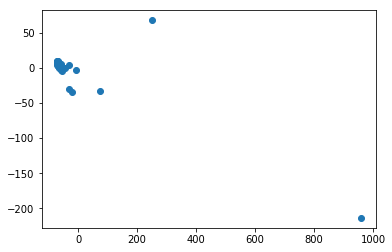

In [22]:
s1=list()
s2=list()
for i in X_pca_test:
    s1.append(i[0])
    s2.append(i[1])    
plt.plot(s1,s2,'o')

Se observa que para ambos dataset los datos encuentran en torno a los valores 0,0, es decir son sonidos que cumplen con la normalidad, sin embargo existen valores extremos que son muy distintos al resto y pueden corresponder a audios viciados o con  contenido equivocado.

> k) Entrene un modelo de Regresión Logı́stica variando el parámetro de regularización $C$ construyendo un gráfico resumen del error en función de este hiper-parámetro. Además entrene un Perceptrón, variando el hiper-parámetro de regularización $\alpha$ en el rango inverso que para la Regresión Logı́stica ¿Por qué? Contruya el mismo gráfico resumen, en función de $C$ o $\alpha$. Compare y comente lo observado.


Entrenamos el regresor logístico con distintos valores de c lo que nos entrega distintos modelos que analizamos el error absoluto medio en base a su predicción.

In [23]:
from sklearn.linear_model import Perceptron,LogisticRegression
from sklearn.metrics import mean_absolute_error

Cs = [0.0001,0.001,0.01,0.1,1,10,100,1000,10000]

predicciones = list()
for c in Cs:
    model = LogisticRegression(penalty='l2', C=c, max_iter=200)
    model = model.fit(X_pca_train, y_train)    
    #predicciones.append( mean_absolute_error(y_test, model.predict(X_pca_test) ) )    
    predicciones.append( model.score(X_pca_test,y_test))


Generamos un gráfico para observar para que valores de c el error es más bajo, se ve  que los valores más bajos del parámetro C genera mejores resultados para el conjunto de prueba.

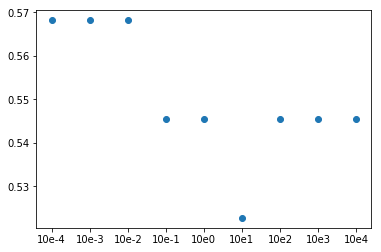

In [24]:
colx = ("10e-4","10e-3","10e-2","10e-1","10e0","10e1","10e2","10e3","10e4")
plt.plot(colx, predicciones ,'o')

A continuación se entrena el perceptrón con valores inversos de c y se observan los resultados en un gráfico.

In [25]:
alphas = [1/c for c in Cs]
predicciones_perc = list()
for a in alphas:
    model = Perceptron(penalty='l2', alpha=a, max_iter=200)
    model = model.fit(X_pca_train, y_train)    
    #predicciones_perc.append( mean_absolute_error(y_test, model.predict(X_pca_test) ) )  
    predicciones_perc.append( model.score(X_pca_test,y_test))

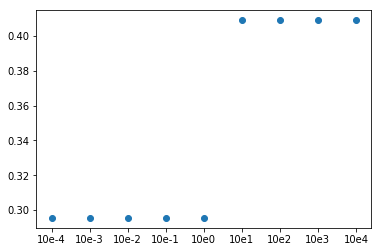

In [26]:
plt.plot(colx, predicciones_perc ,'o')

Se observa que el regresor y el perceptrón generan mejores resultados (score) cuando aumenta el valor de c y disminuye el valor de alpha (aumenta c). Esto ocurre ya que ambos métodos se basan en un método discriminativo que aproxima log-odds( corresponden al logaritmo de la probabilidad que un valor pertenenzca a una clase) usando funciones lineales.

> l) Genere otra representación de los datos a través de la técnica de reducción de dimensionalidad **ICA**, con dimensionalidad $d = 2$. Recuerde que sólo se debe ajustar con el conjunto de entrenamiento, si se muestra un *warning* explique el porqué. Visualice apropiadamente la proyección en 2 dimensiones. Vuelva a realizar el item k) pero para esta nueva representación.

In [27]:
from sklearn.decomposition import FastICA
ica_model = FastICA(n_components=2)
ica_model.fit(X_train)
X_ica_train = ica_model.transform(X_train)
X_ica_test = ica_model.transform(X_test)

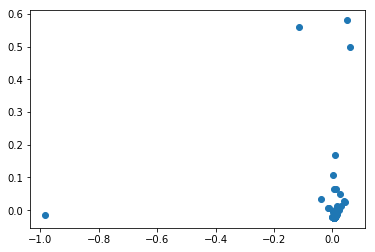

In [28]:
s1=list()
s2=list()
for i in X_ica_train:
    s1.append(i[0])
    s2.append(i[1])    
plt.plot(s1,s2,'o')

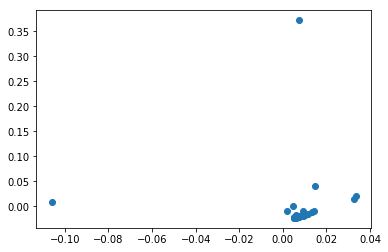

In [29]:
s1=list()
s2=list()
for i in X_ica_test:
    s1.append(i[0])
    s2.append(i[1])    
plt.plot(s1,s2,'o')

Los resultados de ICA muestran distribución de los puntos en torno al 0,0 en ambos conjuntos, no obstante los resultados estan normalizados, esto no demuestra que la reducción de dimensiones sea mejor en comparación a PCA, pero podría generar mejores resultados al entrenar los modelos.

In [31]:
predicciones2 = list()
for c in Cs:
    model = LogisticRegression(penalty='l2', C=c, max_iter=200)
    model = model.fit(X_ica_train, y_train)    
   # predicciones2.append( mean_absolute_error(y_test, model.predict(X_ica_test) ) )
    predicciones2.append( model.score(X_ica_test,y_test))

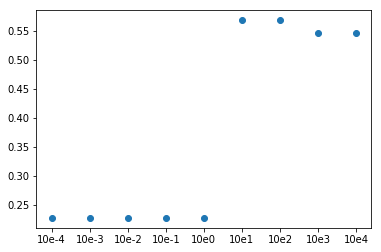

In [32]:
plt.plot(colx, predicciones2 ,'o')

In [33]:
predicciones_perc2 = list()
for a in alphas:
    model = Perceptron(penalty='l2', alpha=a, max_iter=200)
    model = model.fit(X_ica_train, y_train)    
    #predicciones_perc2.append( mean_absolute_error(y_test, model.predict(X_ica_test) ) )  
    predicciones_perc2.append( model.score(X_ica_test,y_test))

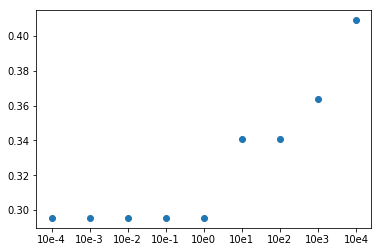

In [34]:
plt.plot(colx, predicciones_perc2 ,'o')

Al igual que antes los resultados entre ambos métodos son similares, generan mejores resultados para valores más grandes de c.

> m) Experimente con diferentes dimensiones $d$ para la proyección de PCA e ICA con el propósito de obtener un modelo con menor error. Construya una tabla o gráfico resumen de los errores o *accuracy*, comente.

In [66]:
def regresor_pca_ica(d, X_train, y_train, X_test, y_test):
    pca_model = PCA(n_components=d)
    pca_model.fit(X_train)
    X_pca_train = pca_model.transform(X_train)
    X_pca_test = pca_model.transform(X_test)

    ica_model = FastICA(n_components=d)
    ica_model.fit(X_train)
    X_ica_train = ica_model.transform(X_train)
    X_ica_test = ica_model.transform(X_test)
    
    Cs = [0.0001,0.001,0.01,0.1,1,10,100,1000,10000]
    predlogic = list()
    for c in Cs:
        model = LogisticRegression(penalty='l2', C=c, max_iter=200)
        model = model.fit(X_pca_train, y_train)    
        predlogic.append( model.score(X_pca_test,y_test))
    max1 = max(predlogic)
    
    predlogic = list()
    for c in Cs:
        model = LogisticRegression(penalty='l2', C=c, max_iter=200)
        model = model.fit(X_ica_train, y_train)    
        predlogic.append( model.score(X_ica_test,y_test))
    max2 = max(predlogic)
    
    return (max1,max2)

def perceptron_pca_ica(d, X_train, y_train, X_test, y_test):
    pca_model = PCA(n_components=d)
    pca_model.fit(X_train)
    X_pca_train = pca_model.transform(X_train)
    X_pca_test = pca_model.transform(X_test)

    ica_model = FastICA(n_components=d)
    ica_model.fit(X_train)
    X_ica_train = ica_model.transform(X_train)
    X_ica_test = ica_model.transform(X_test)
    
    Cs = [0.0001,0.001,0.01,0.1,1,10,100,1000,10000]
    alphas = [1/c for c in Cs]
    predlogic = list()
    for a in alphas:
        model = Perceptron(penalty='l2', alpha=a, max_iter=200)        
        model = model.fit(X_pca_train, y_train)    
        predlogic.append( model.score(X_pca_test,y_test))
    max1 = max(predlogic)
    
    predlogic = list()
    for a in alphas:
        model = Perceptron(penalty='l2', alpha=a, max_iter=200)
        model = model.fit(X_ica_train, y_train)    
        predlogic.append( model.score(X_ica_test,y_test))
    max2 = max(predlogic)
    
    return (max1,max2)

In [67]:
l1 = list()
for i in range(9):
    l1.append(regresor_pca_ica(i+2, X_train, y_train, X_test, y_test))


In [68]:
l2 = list()
for i in range(9):
    l2.append(perceptron_pca_ica(i+2, X_train, y_train, X_test, y_test))

Se generan 2 tablas correspondientes al regresor logistico y perceptrón considerando hasta 10 dimensiones donde los valores para las columnas pca e ica corresponde al máximo valor obtenido en accuracy para algún valor de c y alpha.

In [69]:
tabla1 = pd.DataFrame()
tabla1['Dimensiones'] = (2,3,4,5,6,7,8,9,10)
l1pca = list()
l1ica = list()
for i in l1:
    l1pca.append(i[0])
    l1ica.append(i[1])
tabla1['PCA'] = l1pca
tabla1['ICA'] = l1ica
tabla1

,Dimensiones,PCA,ICA
0,2,0.555556,0.555556
1,3,0.583333,0.555556
2,4,0.722222,0.555556
3,5,0.777778,0.694444
4,6,0.805556,0.694444
5,7,0.805556,0.694444
6,8,0.777778,0.750000
7,9,0.777778,0.805556
8,10,0.750000,0.750000


In [70]:
tabla2 = pd.DataFrame()
tabla2['Dimensiones'] = (2,3,4,5,6,7,8,9,10)
l1pca = list()
l1ica = list()
for i in l2:
    l1pca.append(i[0])
    l1ica.append(i[1])
tabla2['PCA'] = l1pca
tabla2['ICA'] = l1ica
tabla2

,Dimensiones,PCA,ICA
0,2,0.444444,0.444444
1,3,0.444444,0.444444
2,4,0.444444,0.444444
3,5,0.527778,0.472222
4,6,0.500000,0.472222
5,7,0.500000,0.472222
6,8,0.583333,0.555556
7,9,0.638889,0.555556
8,10,0.583333,0.694444


Se observa que los valores para el regresor logístico son mejores que para el perceptrón, tanto para PCA como para ICA, tambien se observa que la presición aumenta al aumentar el número de dimensiones.

> n) Realice otra reducción de dimensionalidad ahora a través de la técnica **LDA**, para representar los datos en $d = 2$ dimensiones. Recuerde que sólo se debe ajustar con el conjunto de entrenamiento, si se muestra un *warning* explique el porqué. Visualice apropiadamente la proyección en 2 dimensiones.

Se presenta un warning ya que existen variables que son colineales, es decir un vector o varios son un representación de una función lineal de otro vector. 

C:\Users\Kristian\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


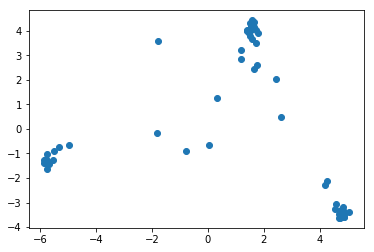

In [71]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
lda_model = LDA(n_components=2)
lda_model.fit(X_train,y_train)
X_lda_train = lda_model.transform(X_train)
X_lda_test = lda_model.transform(X_test)
s1=list()
s2=list()
for i in X_lda_train:
    s1.append(i[0])
    s2.append(i[1])    
plt.plot(s1,s2,'o')

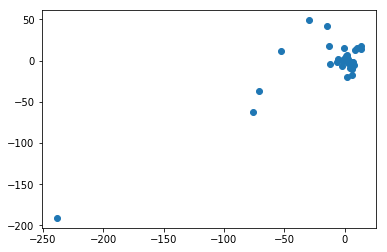

In [72]:
s1=list()
s2=list()
for i in X_lda_test:
    s1.append(i[0])
    s2.append(i[1])    
plt.plot(s1,s2,'o')

> o) Con el propósito de encontrar el mejor modelo vuelva a realizar el item k) en el nuevo espacio generado por la representación según las $d$ dimensiones de la proyección LDA. Esta nueva representación ¿mejora o empeora el desempeño? Explique.


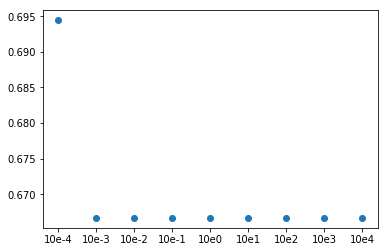

In [73]:
Cs = [0.0001,0.001,0.01,0.1,1,10,100,1000,10000]

predicciones = list()
for c in Cs:
    model = LogisticRegression(penalty='l2', C=c, max_iter=200)
    model = model.fit(X_lda_train, y_train)        
    predicciones.append( model.score(X_lda_test,y_test))
plt.plot(colx, predicciones ,'o')

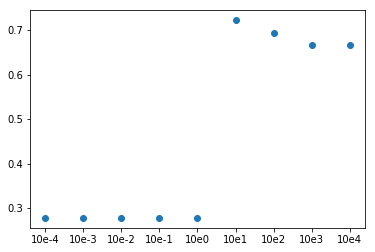

In [74]:
predicciones_perc2 = list()
for a in alphas:
    model = Perceptron(penalty='l2', alpha=a, max_iter=200)
    model = model.fit(X_lda_train, y_train)        
    predicciones_perc2.append( model.score(X_lda_test,y_test))
plt.plot(colx, predicciones_perc2 ,'o')    

LDA entrega mucho mejores resultados en presición  tan solo para 2 dimensiones a medida que el valor de c es más pequeño y alpha aumenta, por lo que se estima que en caso de aumentar el número de dimensiones de LDA, mejorara la accurancy.


> p) Intente mejorar el desempeño de los algoritmos ya entrenados. Diseñe ahora sus propias cracterı́sticas (*feature crafting*) a partir de los datos brutos (secuencia de amplitudes), puede inspirarse en otros trabajos [[6]](#refs), [[7]](#refs)  si desea.

In [127]:
X_fourier.shape

(176, 396900)

In [158]:
def max_REGRESOR_PCA(X_fourier):    
    maximo =0
    for a in range(int(39690/2400)):
        a=a+1
        X_resampled = []
        for i in range(X_fourier.shape[0]):
            sequence = X_fourier[i,:].copy()
            resampled_sequence = signal.resample(sequence, a*2400)
            X_resampled.append(resampled_sequence)
        
        X_resampled = np.array(X_resampled)        
        X_train, X_test, y_train, y_test = train_test_split(X_resampled, y, test_size=0.20, random_state=42)
        std = StandardScaler(with_mean=True, with_std=True)
        std.fit(X_train)
        X_train = std.transform(X_train)
        X_test = std.transform(X_test)
        
        for i in range(20):        
            d = i+10
            pca_model = PCA(n_components=d)
            pca_model.fit(X_train, y_train)
            X_pca_train = pca_model.transform(X_train)
            X_pca_test = pca_model.transform(X_test)        

            Cs = [0.0001,0.001,0.01,0.1,1,10,100,1000,10000]
            predlogic = list()
            for c in Cs:
                model = LogisticRegression(penalty='l2', C=c, max_iter=100)
                model = model.fit(X_pca_train, y_train)    
                predlogic.append( model.score(X_pca_test,y_test))        

            max_local = max(predlogic)
            
            if max_local > maximo:             
                maximo = max_local
                print((a*2400),maximo, d)
                dimensiones = d
    
    return (maximo,d)
    

In [159]:
max_REGRESOR_PCA(X_fourier)

2400 0.75 10
2400 0.8055555555555556 12
2400 0.8333333333333334 13
2400 0.8611111111111112 29


(0.8611111111111112, 29)

Para la entrada se ulizo tanto la transformada de furier como la estandarización de los vectores, lo generá mejores resultados que al no aplicarlos, por lo  que para mejorar resultados se probó iterando distintas dimensionalidades para la función signal que transforma las características reduciendo dimensiones antes del entrenamiento, se probarón distintas combinaciónes de modelos y de reductores de dimensiones (PCA,ICA, LDA) y la combianción que generó los mejores resultados fue la reducción dimensiones inicial previa al modelo con 2400 características, a continuación se utilizó un reductor de dimensiones PCA y un regresor logístico, lo que entregó un máximo local de 0.8611 superior a los valores encontrados con anterioridad. 